In [42]:
import numpy as np
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from Mesh.Charges_utils import get_charges_list
from Model.Solutions_utils import Solution_utils

from Mesh.Mesh import Domain_Mesh
from Post.Postcode import Postprocessing as Post
from Simulation import get_simulation_name

simulation_name,results_path,main_path,logger = get_simulation_name(os.path.join(os.path.dirname(os.getcwd()), 'dataset.py'))

file_path = os.getcwd()

In [53]:

molecule = 'sphere_0.2'


Rs = {'born_ion': 1,
      'methanol': 2.54233,
      'arg': 5.9695745,
      'sphere': 1.2,
      'sphere_+1-1': 1.2,
      'sphere_+1+1': 1.2,
      'sphere_+2-1': 1.2,
      'sphere_+1_D': 1.2,
      'sphere_0.2': 1.2}

Model = Solution_utils()

q_list = get_charges_list(os.path.join(os.getcwd(),molecule,f'{molecule}.pqr'))
Model.epsilon_1 = 1
Model.epsilon_2 = 80
Model.kappa = 0.125
Model.pi = np.pi
Model.q_list = q_list

n = len(Model.q_list)
Model.qs = np.zeros(n)
Model.x_qs = np.zeros((n,3))
for i,q in enumerate(Model.q_list):
    Model.qs[i] = q.q
    Model.x_qs[i,:] = q.x_q
Model.total_charge = np.sum(Model.qs)

dR = 0.1
R_mol = Rs[molecule]
Rmin = dR + R_mol
Rmax = Rmin + 3


In [54]:
q_list

[Charges(q=0.2, x_q=array([0., 0., 0.]), r_q=1.2, atom_name='H', res_name='SPH', res_num='1', ion_r_explode=3.5)]

### Calculate Solvation energy

In [55]:
phi_q = Model.Harmonic_spheres(Model.x_qs,'molecule',R_mol)
print(Model.solvation_energy_phi_qs(phi_q))
print(phi_q)
Model.solvation_energy_phi_qs(phi_q)

/home/martinachondo/PINN/code/Model/Solutions_utils.py:111: RuntimeWarning: invalid value encountered in scalar divide
  zenit = np.arccos(x[K, 2] / rho)
/home/martinachondo/PINN/code/Model/Solutions_utils.py:122: RuntimeWarning: invalid value encountered in scalar divide
  zenit_k = np.arccos(xq[k, 2] / rho_k)


nan

### Plot phi

In [56]:
domain_properties = {
    'molecule': molecule,
    }
    
mesh_properties = {
        'vol_mx_interior': 0.05,
        'vol_max_exterior': 0.5,
        'density_mol': 2,
        'density_border': 3,
        'dx_experimental': 0.8,
        'N_pq': 100,
        'G_sigma': 0.04,
        'mesh_generator': 'msms',
        'dR_exterior': 5
        }



Mol_mesh = Domain_Mesh(domain_properties['molecule'], 
                mesh_properties=mesh_properties, 
                save_points=True,
                path=main_path,
                simulation=simulation_name
                )

Post.mesh = Mol_mesh
Model.mesh = Mol_mesh
Model.DTYPE = 'float64'

In [57]:
N=300
x0=np.array([0,0,0])
theta=0
phi=np.pi/2

r = np.linspace(-Mol_mesh.R_exterior,Mol_mesh.R_exterior,N)
x = x0[0] + r * np.sin(phi) * np.cos(theta) + Mol_mesh.centroid[0]
y = x0[1] + r * np.sin(phi) * np.sin(theta) + Mol_mesh.centroid[1]
z = x0[2] + r * np.cos(phi) + Mol_mesh.centroid[2]
points = np.stack((x.ravel(), y.ravel(), z.ravel()), axis=1)
X_in,X_out,_ = Post.get_interior_exterior(Post,points)

X = [X_in,X_out,x0]

In [58]:
field = 'react'

u_in_Yuk = Model.phi_known('G_Yukawa',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_Yuk = Model.phi_known('G_Yukawa',field,X_out,'solvent',Mol_mesh.R_max_dist)

u_in_Born = Model.phi_known('analytic_Born_Ion',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_Born = Model.phi_known('analytic_Born_Ion',field,X_out,'solvent',Mol_mesh.R_max_dist)

u_in_Har = Model.phi_known('Harmonic_spheres',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_Har = Model.phi_known('Harmonic_spheres',field,X_out,'solvent',Mol_mesh.R_max_dist)


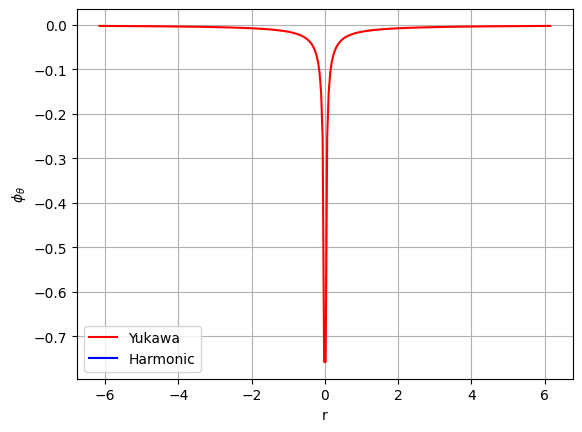

In [60]:
fig,ax = Post.plot_phis_line([(u_in_Yuk,u_out_Yuk),(u_in_Har,u_out_Har)],X,['Yukawa','Harmonic'])
#ax.set_ylim([np.min(u_out_Har)-0.01,np.max(u_in_Har)+0.01])

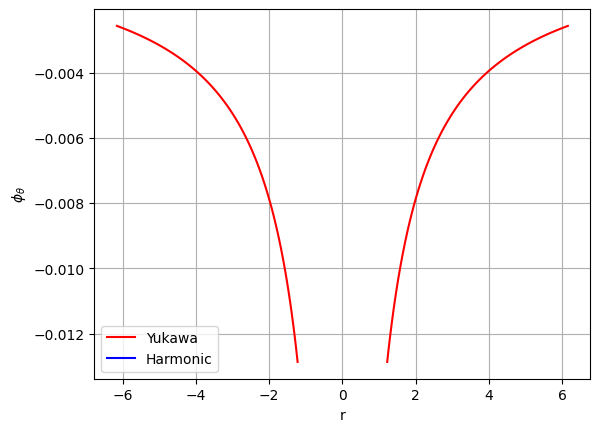

In [61]:
fig,ax = Post.plot_phis_line([(u_in_Yuk,u_out_Yuk),(u_in_Har,u_out_Har)],X,['Yukawa','Harmonic'],domain='solvent')
# ax.set_ylim([-0.001,0.003])

### Create data_known file

In [62]:

def calculate_print_phi(domain,method, num_points):

    R = R_mol if domain == 'molecule' else Rmax if domain == 'solvent' else None
    x = np.random.uniform(-R, R, num_points)
    y = np.random.uniform(-R, R, num_points)
    z = np.random.uniform(-R, R, num_points)
    r = np.sqrt(x**2+y**2+z**2)
    X = np.stack([x,y,z], axis=1)

    phi_values = Model.phi_known(method,'phi',X,domain,R_mol)

    if domain == 'molecule':
        with open(os.path.join(file_path,molecule,'data_known.dat'), 'a') as file:
            for i in range(num_points):
                condition = 1 if r[i] <= R_mol else 2
                if r[i]<R_mol:
                    file.write(f"{condition} {x[i]} {y[i]} {z[i]} {phi_values[i]}\n")

    elif domain == 'solvent':
        with open(os.path.join(file_path,molecule,'data_known.dat'), 'a') as file:
            for i in range(num_points):
                condition = 1 if r[i] <= R_mol else 2
                if r[i]>Rmin:
                    file.write(f"{condition} {x[i]} {y[i]} {z[i]} {phi_values[i]}\n")

In [63]:
with open(os.path.join(file_path,molecule,'data_known.dat'), 'w') as file:
    pass
calculate_print_phi('solvent','Harmonic_spheres',300)
#calculate_print_phi('molecule','Harmonic_spheres',300)

print('File created')